# Tensorflow model

This is my attempt at moving to a tensorflow approach to the problem (as opposed to pytorch) because this is an easier starting point for edge computing. 

Note 1: this is currently optimised for the M1 macs, so the GPU calls may need to change for other machines.
Note 2: I have used the gbif_species_trainer environment for this notebook.To implement this: 

```
conda create -n gbif_species_trainer python=3.9
conda activate gbif_species_trainer
```

In [2]:
import tensorflow as tf
import os
import numpy as np

# show the tensorflow package version
print(tf.__version__)

2.13.0-rc0


👆 make sure you are not using 2.11, as this will [fall over with the M1 macs](https://developer.apple.com/forums/thread/721619). 

```

## Load in the data

In [3]:
data_dir = '/Users/kgoldmann/Documents/Projects/AMBER/on_device_classifier/01_data_download/output_data/gbif_test'

In [4]:
# list number of jpg files in subdirectories
fls = []

for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpg'):
            #print(os.path.join(subdir, file))
            fls.append(os.path.join(subdir, file))


print(len(fls))


# print the directories in data_dir
subds = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
# remove .DS_Store
if os.path.exists(os.path.join(data_dir, '.DS_Store')):
    subds.remove(os.path.join(data_dir, '.DS_Store'))

#if data_counts exists, remove
if os.path.exists(os.path.join(data_dir, 'data_counts.txt')):
    os.remove(os.path.join(data_dir, 'data_counts.txt'))


print(subds)

subds = subds[0:5]


for sd in subds:
    print(sd)
    fls = []

    for subdir, dirs, files in os.walk(sd):
        for file in files:
            if file.endswith('.jpg'):
                #print(os.path.join(subdir, file))
                fls.append(os.path.join(subdir, file))
    print(len(fls))




2019
['/Users/kgoldmann/Documents/Projects/AMBER/on_device_classifier/01_data_download/output_data/gbif_test/Acasis', '/Users/kgoldmann/Documents/Projects/AMBER/on_device_classifier/01_data_download/output_data/gbif_test/Abraxas', '/Users/kgoldmann/Documents/Projects/AMBER/on_device_classifier/01_data_download/output_data/gbif_test/Aethalura']
/Users/kgoldmann/Documents/Projects/AMBER/on_device_classifier/01_data_download/output_data/gbif_test/Acasis
500
/Users/kgoldmann/Documents/Projects/AMBER/on_device_classifier/01_data_download/output_data/gbif_test/Abraxas
1019
/Users/kgoldmann/Documents/Projects/AMBER/on_device_classifier/01_data_download/output_data/gbif_test/Aethalura
500


In [5]:
batch_size = 64
img_height = 300
img_width = 300

## Split into test, train, validation

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2019 files belonging to 3 classes.
Using 1616 files for training.
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-05-25 16:19:23.815816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-25 16:19:23.815843: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_batches = tf.data.experimental.cardinality(val_ds)
print(val_batches)


test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Found 2019 files belonging to 3 classes.
Using 403 files for validation.
tf.Tensor(7, shape=(), dtype=int64)


In [11]:
# save test_ds and val_ds to disk
tf.data.experimental.save(test_ds, '/Users/kgoldmann/Documents/Projects/AMBER/on_device_classifier/02_model_training/saved_models/1/test_batch')
tf.data.experimental.save(val_ds, '/Users/kgoldmann/Documents/Projects/AMBER/on_device_classifier/02_model_training/saved_models/1/val_batch')

# load test_df and val_df from disk
test_ds2 = tf.data.experimental.load('/Users/kgoldmann/Documents/Projects/AMBER/on_device_classifier/02_model_training/saved_models/1/test_batch', (tf.TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), tf.TensorSpec(shape=(None,), dtype=tf.int32, name=None)))





2023-05-23 10:44:22.005081: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [403]
	 [[{{node Placeholder/_4}}]]
2023-05-23 10:44:22.005269: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [403]
	 [[{{node Placeholder/_0}}]]
2023-05-23 10:44:23.172387: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [403]
	 [

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 4874675493141186020


In [8]:
class_names = train_ds.class_names
print(class_names)

['Abraxas', 'Acasis', 'Aethalura']


2023-05-22 10:25:24.040937: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1616]
	 [[{{node Placeholder/_4}}]]
2023-05-22 10:25:24.041124: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1616]
	 [[{{node Placeholder/_4}}]]


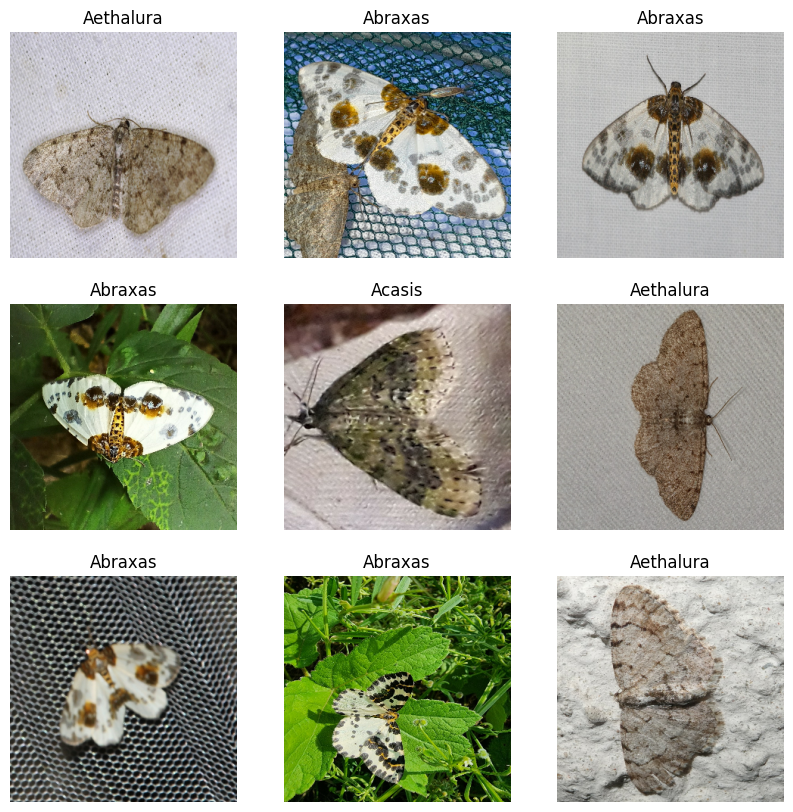

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2023-05-22 10:25:26.374283: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1616]
	 [[{{node Placeholder/_4}}]]
2023-05-22 10:25:26.374470: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1616]
	 [[{{node Placeholder/_0}}]]


(64, 300, 300, 3)
(64,)


## Standardize the data

In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


2023-05-22 10:25:29.352994: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1616]
	 [[{{node Placeholder/_4}}]]
2023-05-22 10:25:29.353178: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1616]
	 [[{{node Placeholder/_4}}]]


0.0 0.8650336


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train the model

In [14]:
num_classes = len(class_names)


print(num_classes)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])



3


In [15]:
model.compile(
  optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.001, momentum=0.9),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])



In [16]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30


2023-05-22 10:25:34.744416: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1616]
	 [[{{node Placeholder/_4}}]]
2023-05-22 10:25:34.744642: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1616]
	 [[{{node Placeholder/_0}}]]
2023-05-22 10:25:35.055060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - ETA: 0s - loss: 1.0332 - accuracy: 0.4901

2023-05-22 10:25:40.483037: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [403]
	 [[{{node Placeholder/_4}}]]
2023-05-22 10:25:40.483250: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [403]
	 [[{{node Placeholder/_0}}]]
2023-05-22 10:25:40.536024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 7s 209ms/step - loss: 1.0332 - accuracy: 0.4901 - val_loss: 0.9589 - val_accuracy: 0.5714
Epoch 2/30
26/26 [==============================] - 4s 161ms/step - loss: 0.9329 - accuracy: 0.5588 - val_loss: 0.8536 - val_accuracy: 0.6259
Epoch 3/30
26/26 [==============================] - 4s 152ms/step - loss: 0.8907 - accuracy: 0.5699 - val_loss: 0.8564 - val_accuracy: 0.5850
Epoch 4/30
26/26 [==============================] - 4s 153ms/step - loss: 0.8652 - accuracy: 0.5959 - val_loss: 0.8298 - val_accuracy: 0.6054
Epoch 5/30
26/26 [==============================] - 4s 153ms/step - loss: 0.8377 - accuracy: 0.6052 - val_loss: 0.8251 - val_accuracy: 0.6054
Epoch 6/30
26/26 [==============================] - 4s 153ms/step - loss: 0.8120 - accuracy: 0.6126 - val_loss: 0.8124 - val_accuracy: 0.6463
Epoch 7/30
26/26 [==============================] - 4s 154ms/step - loss: 0.7784 - accuracy: 0.6386 - val_loss: 0.7999 - val_accuracy: 0.6395
Epoch 8/30
26/26 

In [18]:
export_dir = 'saved_models/1'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_models/1/assets


INFO:tensorflow:Assets written to: saved_models/1/assets


In [19]:
# print val_accuracy
print('Model accuracy: ')
model.evaluate(test_ds)

Model accuracy: 


2023-05-22 10:57:51.460608: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [403]
	 [[{{node Placeholder/_4}}]]
2023-05-22 10:57:51.460827: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [403]
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 1s 60ms/step - loss: 0.7209 - accuracy: 0.7070


[0.7209043502807617, 0.70703125]

In [17]:
# print the probability of each class
print('Model probability: ')
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_ds)
print(predictions[0])


# print the class with the highest probability
print('\nPredicted Model class: ')
print(class_names[np.argmax(predictions[0])])

# print the actual class
print('\nActual Model class: ')
for image_batch, labels_batch in test_ds:
    print(class_names[labels_batch[0]])
    break



Model probability: 


2023-05-18 15:24:52.611432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 47ms/step
[4.534854e-04 8.234691e-03 9.913119e-01]

Predicted Model class: 
Aethalura

Actual Model class: 
Acasis


In [18]:
# Print a confusion matrix
import pandas as pd
#import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = max_prob = np.argmax(predictions, axis=1)
y_true = []

probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

for image_batch, labels_batch in test_ds:
    # print(np.argmax(probability_model.predict(image_batch)))
    # y_pred.append(np.argmax(probability_model.predict(image_batch)))
    y_true.append(labels_batch.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

y_pred = y_pred.flatten()
y_true = y_true.flatten()

In [19]:
# Index class_names using unique y_pred

print([class_names[i] for i in list(np.unique(y_pred))])

print([class_names[i] for i in list(np.unique(y_true))])


['Abraxas', 'Acasis', 'Aethalura']
['Abraxas', 'Acasis', 'Aethalura']


In [20]:
print(y_pred)
print(y_true)

[2 0 0 0 1 2 0 0 2 0 1 0 2 0 2 0 0 1 1 0 0 2 0 0 0 0 2 0 1 0 2 0 0 0 0 0 0
 0 2 0 2 0 0 0 1 0 0 0 0 0 2 0 0 2 0 0 0 2 0 1 0 0 0 1 0 0 0 1 0 2 0 0 1 2
 2 0 0 2 2 0 0 1 0 1 2 1 0 0 1 0 2 1 1 0 1 0 0 1 2 0 0 0 0 0 2 0 0 0 0 1 2
 0 0 2 1 0 0 1 0 0 0 0 0 0 0 1 2 1 2 0 2 2 2 0 0 2 1 2 2 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 2 0 0 2 2 1 2 0 0 1 1 0 1 2 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 2 1 0
 2 0 0 0 1 1 0 2 0 0 2 2 0 2 1 2 0 0 0 1 0 0 1 2 0 2 0 0 1 0 0 0 0 1 1 2 1
 0 0 0 0 1 0 0 2 0 0 2 2 0 2 0 0 0 0 1 0 0 1 0 1 1 0 1 2 2 0 2 2 0 2]
[0 0 2 0 0 1 2 2 2 1 0 1 2 2 0 2 0 0 2 2 1 2 0 0 1 1 1 2 2 2 0 2 2 1 0 1 1
 1 0 0 2 1 2 1 0 0 2 1 0 1 0 0 1 1 0 0 2 0 0 0 1 0 1 2 1 2 0 0 2 2 0 1 0 1
 1 1 2 0 2 1 0 0 2 0 1 1 1 1 1 0 2 1 1 0 1 0 2 0 0 0 0 1 1 0 2 1 0 0 1 0 0
 0 1 0 0 1 1 1 2 0 1 1 0 1 0 1 0 0 1 0 0 0 1 2 1 0 2 0 0 1 0 0 2 1 0 1 2 0
 0 1 0 2 1 0 2 0 1 2 0 0 0 1 0 1 2 0 0 0 2 0 0 0 0 0 1 0 0 2 0 0 2 0 0 0 2
 0 1 0 0 2 0 0 2 2 0 0 2 1 2 1 1 0 0 2 0 0 1 0 0 0 0 1 0 0 2 0 0 0 1 0 0 1
 1 1 2 2 2 1 0 0 1 0 0 1 0 0 0

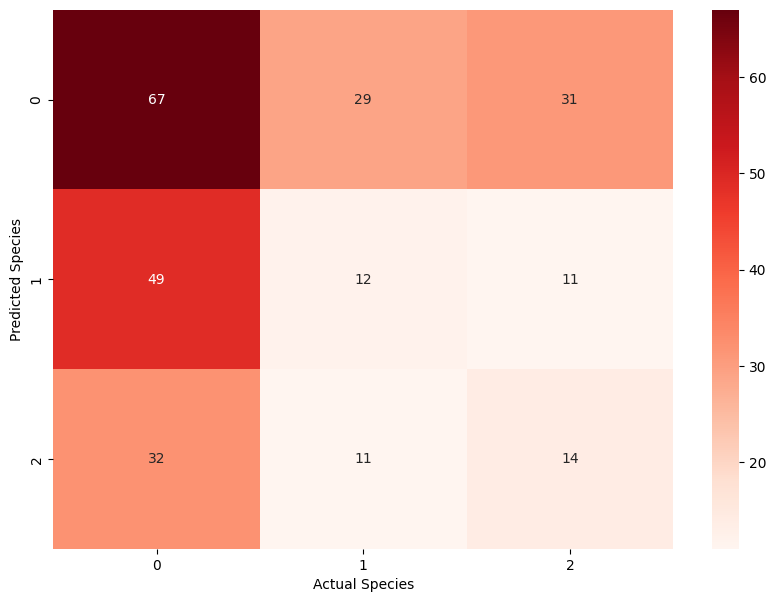

In [21]:
import seaborn as sn

confusion_mtx = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion_mtx)#, index = [class_names[i] for i in list(np.unique(y_pred))],
                    #columns = [class_names[i] for i in list(np.unique(y_true))])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Reds")

plt.xlabel('Actual Species')
plt.ylabel('Predicted Species')

plt.show()